# Проект "Компьютерное зрение"
# на тему "Определение возраста покупателей"

**Описание проекта**  
  
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

  - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
  - Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

**План выполнения проекта**

Сохранена предложенная структура проекта    
После каждого пункта следуют выводы и в заключение подводится общий итог
  - 1 Исследовательский анализ данных
    - импорт библиотек, загрузка датасета
    - вывод информациио данных
    - построение гистограммы целевой переменной
    - вывод образцов данных
  - 2 Обучение модели
    - выбор модели
    - подбор параметра для достижения целевой метрики
  - 3 Анализ обученной модели
    - анализ обученной модели и общий вывод

## Исследовательский анализ данных

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_train(path='/datasets/faces/'):
    labels = pd.read_csv(path + 'labels.csv')
    return ImageDataGenerator(validation_split=0.25, rescale=1./255, horizontal_flip=True)\
            .flow_from_dataframe(dataframe=labels, 
                                 directory=path + 'final_files/',
                                 x_col='file_name', 
                                 y_col='real_age', 
                                 target_size=(224, 224), 
                                 batch_size=32, 
                                 class_mode='raw',
                                 subset='training', 
                                 seed=12345)

In [2]:
%%time
labels = pd.read_csv('/datasets/faces/labels.csv')
train_gen_flow = load_train()

Found 5694 validated image filenames.
CPU times: user 358 ms, sys: 257 ms, total: 615 ms
Wall time: 1min 23s


Датасет представляет собой фото людей с разметкой возраста от 1 до 100 лет.

In [3]:
labels.info()
print('\n')
print(labels.describe(), '\n')
print('Дубликатов:', labels.duplicated().sum())
labels.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000 

Дубликатов: 0


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Генератор возвращает батчи с аугментированными и нормализованные данными по 32 экземпляра из обучающего датасета - 5694 изображения размером (224, 224, 3).

In [4]:
features, target = next(train_gen_flow)

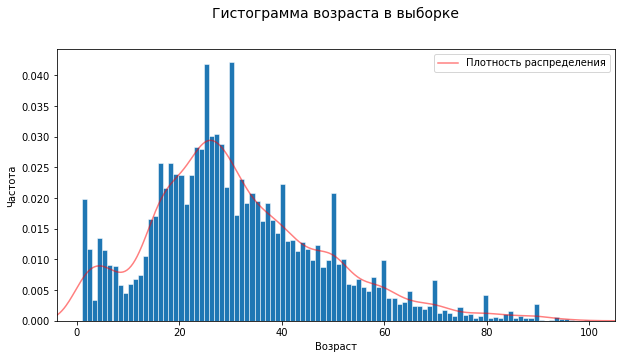

In [5]:
ax = labels.real_age.plot.hist(bins=100, density=True, edgecolor='w', linewidth=.5, figsize=(10,5))
xlim = ax.get_xlim()
labels.real_age.plot.density(color='r', alpha=0.5)
ax.set_xlim(xlim)
ax.legend(labels=['Плотность распределения'])
ax.set_xlabel('Возраст')
ax.set_ylabel('Частота')
ax.set_title('Гистограмма возраста в выборке\n', fontsize=14, pad=15);

Данных для анализа нужного размера достаточно (7591), распределение целевой переменной близко к нормальному, с медианой и средним около 30 лет, с характерными пиками возрастов, кратных 5 и 10 годам (юбилеи, округления) и несколько бОльшим количеством детских фото.  

In [6]:
# небольшая локализация

def years(n):
    return str(n) + ' ' + ('лет' if n in range(11, 15) 
                           else 'год' if n%10 ==1 
                           else 'года' if n%10 in range(2,5) 
                           else 'лет')

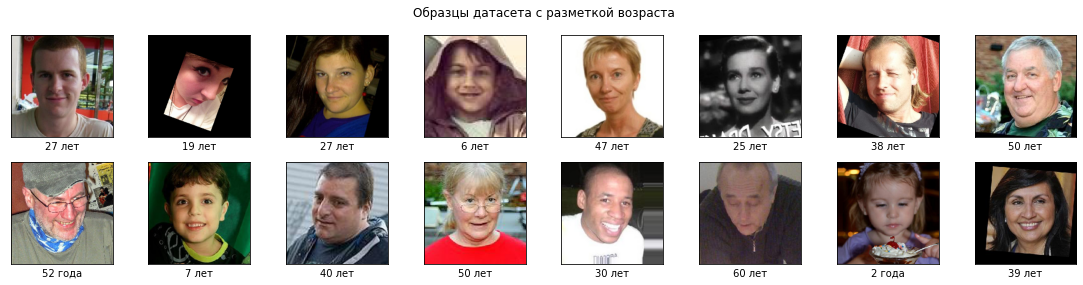

In [7]:
fig = plt.figure(figsize=(16, 4))
plt.suptitle('Образцы датасета с разметкой возраста')

for i in range(16):
    fig.add_subplot(2, 8, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(years(target[i]))
    plt.tight_layout()

Основные выводы, влияющие на обучение модели:
  - подходящий вариант для изображений - предобученная остаточная сверточная нейронная сеть ResNet-50
  - результат предсказания регрессии - число, поэтому выходной нейрон будет один; в предпоследнем слое должна быть функция, усредняющая информацию по всему изображению
  - подходящая функция активации - ReLU, т.к. нам нужны только положительные результаты
  - в данных присутствуют фото, сдвинутые и повернутые на некоторые углы, поэтому дополнительной аугментации не требуется

**Выводы по п 1**
  - датасет загружен успешно
  - данные представляют собой фото людей с разметкой возраста
  - дано примерное описание предполагаемой модели нейронной сети

## Обучение модели

Здесь приведен окончательный вариант кода.  
Используется стандартный вариант модели ResNet-50, с добавлением слоя глобального усреднения и полносвязного выходного слоя с одним элементом для регрессии.

```python
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd

def load_train(path='/datasets/faces/'):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255) 
    train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels, 
                                                   directory=path + 'final_files/',
                                                   x_col='file_name', 
                                                   y_col='real_age', 
                                                   target_size=(224, 224), 
                                                   batch_size=32, 
                                                   class_mode='raw',
                                                   subset='training', 
                                                   seed=12345)
    return train_gen_flow

def load_test(path='/datasets/faces/'):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255) 
    test_gen_flow = test_datagen.flow_from_dataframe(dataframe=labels, 
                                                   directory=path + 'final_files/',
                                                   x_col='file_name', 
                                                   y_col='real_age', 
                                                   target_size=(224, 224), 
                                                   batch_size=32, 
                                                   class_mode='raw',
                                                   subset='validation', 
                                                   seed=12345)
    return test_gen_flow

def create_model(input_shape=(224, 224, 3)):
    model = Sequential()
    model.add(ResNet50(input_shape=input_shape, weights='imagenet', include_top=False))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer=Adam(lr=0.0001), loss='mae', metrics=['mae'])
    print(model.summary())
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    history = model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    print('History MAE (trainning set):', history.history['mae'])
    print('History MAE (validation set):', history.history['val_mae'])
    features, target = next(load_train())
    print('Predicted values:', list(np.concatenate(model.predict(features)).flat))
    print('Real values', target)
    return model

```

Результат обучения модели с оптимизатором Adam с параметрами по умолчанию (learning rate = 0.001)  
(здесь и далее в выводе удалены пустые строки и лишние сообщения):

...  
Epoch 1/10 178/178 - 64s - loss: 12.7870 - mae: 12.7873 - val_loss: 13.8817 - val_mae: 13.8600  
Epoch 2/10 178/178 - 38s - loss: 10.9992 - mae: 11.0002 - val_loss: 16.2717 - val_mae: 16.2526  
Epoch 3/10 178/178 - 38s - loss: 10.0561 - mae: 10.0574 - val_loss: 13.7322 - val_mae: 13.6781  
Epoch 4/10 178/178 - 39s - loss: 9.2390 - mae: 9.2401 - val_loss: 12.6573 - val_mae: 12.6086  
Epoch 5/10 178/178 - 39s - loss: 8.4328 - mae: 8.4336 - val_loss: 12.1756 - val_mae: 12.1403  
Epoch 6/10 178/178 - 39s - loss: 7.8763 - mae: 7.8771 - val_loss: 8.8578 - val_mae: 8.7997  
Epoch 7/10 178/178 - 39s - loss: 7.4649 - mae: 7.4659 - val_loss: 13.1237 - val_mae: 13.1085  
Epoch 8/10 178/178 - 40s - loss: 6.9261 - mae: 6.9263 - val_loss: 11.7639 - val_mae: 11.7768  
Epoch 9/10 178/178 - 41s - loss: 6.3983 - mae: 6.3986 - val_loss: 10.3233 - val_mae: 10.2954  
Epoch 10/10 178/178 - 39s - loss: 6.0408 - mae: 6.0412 - val_loss: 11.8864 - val_mae: 11.8589  
60/60 - 10s - loss: 11.8864 - mae: 11.8589  
Test MAE: 11.8589  

Возможно, модель "пропускает" оптимальные значения, уменьшаем скорость обучения (learning rate = 0.0001):

...  
Test MAE: 6.1352  

Целевое значение MAE достигнуто, повторяем обучение и "заказываем" детализацию модели,   
историю обучения для визуализации результата, а также предсказания для наших образцов.

Found 5694 validated image filenames.  
Found 1897 validated image filenames.  
  
`Model: "sequential"`  
`_________________________________________________________________`  
`Layer (type)                 Output Shape              Param #   `  
`=================================================================`  
`resnet50 (Model)             (None, 7, 7, 2048)        23587712  `  
`_________________________________________________________________`  
`global_average_pooling2d (Gl (None, 2048)              0         `  
`_________________________________________________________________`  
`dense (Dense)                (None, 1)                 2049      `  
`=================================================================`  
`Total params: 23,589,761`  
`Trainable params: 23,536,641`  
`Non-trainable params: 53,120`  
`_________________________________________________________________`  
  
Train for 178 steps, validate for 60 steps  
  
Epoch 1/10 178/178 - 48s - loss: 11.3148 - mae: 11.3157 - val_loss: 27.7998 - val_mae: 27.8158  
Epoch 2/10 178/178 - 39s - loss: 6.7925 - mae: 6.7924 - val_loss: 25.0221 - val_mae: 25.0163  
Epoch 3/10 178/178 - 43s - loss: 5.5539 - mae: 5.5543 - val_loss: 11.9762 - val_mae: 11.9340  
Epoch 4/10 178/178 - 45s - loss: 4.7990 - mae: 4.7995 - val_loss: 8.3955 - val_mae: 8.4122  
Epoch 5/10 178/178 - 43s - loss: 4.3141 - mae: 4.3144 - val_loss: 7.7436 - val_mae: 7.7617  
Epoch 6/10 178/178 - 41s - loss: 3.9169 - mae: 3.9170 - val_loss: 6.4067 - val_mae: 6.4336  
Epoch 7/10 178/178 - 46s - loss: 3.5506 - mae: 3.5510 - val_loss: 6.4812 - val_mae: 6.4891  
Epoch 8/10 178/178 - 44s - loss: 3.2494 - mae: 3.2493 - val_loss: 6.2760 - val_mae: 6.2881  
Epoch 9/10 178/178 - 47s - loss: 3.0537 - mae: 3.0540 - val_loss: 6.3104 - val_mae: 6.3154  
Epoch 10/10 178/178 - 64s - loss: 2.8222 - mae: 2.8222 - val_loss: 6.1757 - val_mae: 6.1789  
  
History MAE (trainning set): [11.315681, 6.7924013, 5.554264, 4.7995143, 4.3144403, 3.9170444, 3.550952, 3.2493074, 3.0540214, 2.8222353]  
  
History MAE (validation set): [27.815826, 25.016338, 11.934005, 8.41218, 7.761728, 6.4335675, 6.489122, 6.288084, 6.315421, 6.178942]  
  
Found 5694 validated image filenames.  
  
Predicted values: [24.392979, 17.476295, 21.841583, 7.222267, 43.575397, 20.290016, 35.080185, 54.97165, 59.75424, 4.799663, 30.056847, 42.425903, 33.57261, 64.32001, 2.021374, 40.81645, 47.141453, 65.63241, 49.350155, 51.23717, 10.179424, 42.541176, 0.84322417, 17.926147, 25.88402, 34.85257, 49.405262, 22.671827, 43.277184, 35.297302, 38.05703, 83.69074]  
  
Real values [27 19 27  6 47 25 38 50 52  7 40 50 30 60  2 39 55 65 51 50 10 40  1 17 30 35 61 25 48 37 43 90]  
  
60/60 - 11s - loss: 6.1757 - mae: 6.1789  
  
**Test MAE: 6.1789**  

(После этого обучение проводилось еще несколько раз, на модели с этими параметрами были получены значения MAE в диапазоне от 5.93 до 6.95)

**Выводы по п 2**
  - была использована простая модель ResNet-50 без дополнительных слоев, без замораживания предобученных слоев
  - обучение модели со скоростью 0.0001 позволило достичь целевого результата MAE < 8

## Анализ обученной модели

Полученная модель позволяет предсказывать возраст человека по фотографии со средней ошибкой менее 8 лет.  
Отобразим историю (MAE является и функцией потерь, и метрикой)

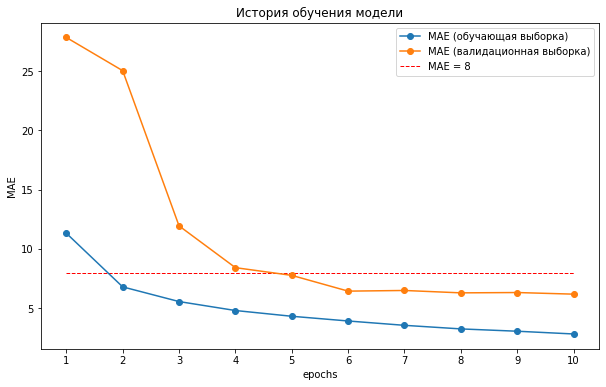

In [8]:
mae = [11.315681, 6.7924013, 5.554264, 4.7995143, 4.3144403, 3.9170444, 3.550952, 3.2493074, 3.0540214, 2.8222353]
val_mae = [27.815826, 25.016338, 11.934005, 8.41218, 7.761728, 6.4335675, 6.489122, 6.288084, 6.315421, 6.178942] 

plt.figure(figsize=(10, 6))
plt.title("История обучения модели")
plt.xlabel("epochs")
plt.ylabel("MAE")
x = range(1,11)

plt.hlines(y=8, xmin=1, xmax=10, color='r', linestyle='dashed', label='MAE = 8', linewidth=1)     
plt.plot(x, mae, label = 'MAE (обучающая выборка)', marker = 'o')
plt.plot(x, val_mae, label = 'MAE (валидационная выборка)', marker = 'o')
plt.legend()
plt.xticks(x);

Понадобилось 5 эпох, чтобы получить требуемый результат, далее метрика стабильно меньше.  
Посмотрим на предсказания по нашим образцам (первые 16 значений из батча в выводе модели).

In [9]:
predictions = [24.392979, 17.476295, 21.841583, 7.222267, 43.575397, 20.290016, \
               35.080185, 54.97165, 59.75424, 4.799663, 30.056847, 42.425903, \
               33.57261, 64.32001, 2.021374, 40.81645]
real = [eval(x) for x in str.split("27 19 27 6 47 25 38 50 52 7 40 50 30 60 2 39")]

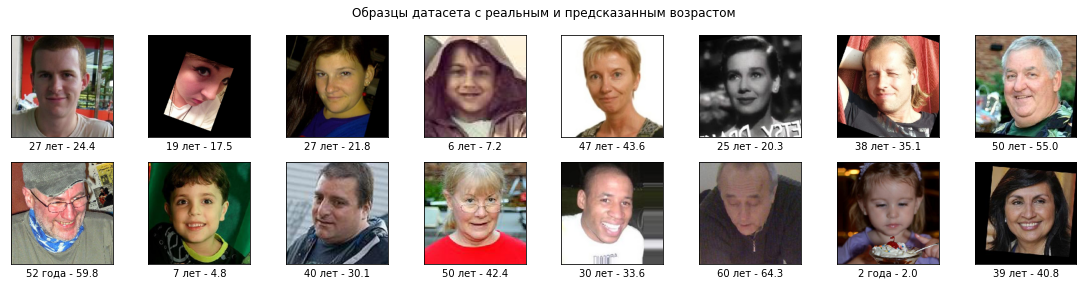

In [10]:
fig = plt.figure(figsize=(16, 4))
plt.suptitle('Образцы датасета с реальным и предсказанным возрастом')

for i in range(16):
    fig.add_subplot(2, 8, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(years(target[i]) + ' - ' + str(round(predictions[i],1)))
    plt.tight_layout()

```python
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd

def load_train(path='/datasets/faces/'):
    global tgf_hf       # train generator flow, horizontal flip 
    global tgf_hf_vf    # train generator flow, horizontal flip, vertical flip, rotation
    global tgf_hf_vf_ra # train generator flow, horizontal flip, vertical flip, rotation
    labels = pd.read_csv(path + 'labels.csv')
    def get_flow(data_gen):
        return data_gen.flow_from_dataframe(dataframe=labels, 
                                            directory=path + 'final_files/', 
                                            x_col='file_name', y_col='real_age', 
                                            target_size=(224, 224), batch_size=32, 
                                            class_mode='raw', subset='training', seed=12345)

    train_gen_flow = get_flow(ImageDataGenerator(validation_split=0.25, rescale=1./255) )
    try:
        tgf_hf
    except:
        tgf_hf = get_flow(ImageDataGenerator(validation_split=0.25, 
                                             rescale=1./255, 
                                             horizontal_flip=True) )
        tgf_hf_vf = get_flow(ImageDataGenerator(validation_split=0.25, 
                                                rescale=1./255, 
                                                horizontal_flip=True, 
                                                vertical_flip=True))
        tgf_hf_vf_ra = get_flow(ImageDataGenerator(validation_split=0.25, 
                                                   rescale=1./255, 
                                                   horizontal_flip=True, 
                                                   vertical_flip=True, 
                                                   rotation_range=90))

    return train_gen_flow

def load_test(path='/datasets/faces/'):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255) 
    test_gen_flow = test_datagen.flow_from_dataframe(dataframe=labels, 
                                                   directory=path + 'final_files/',
                                                   x_col='file_name', 
                                                   y_col='real_age', 
                                                   target_size=(224, 224), 
                                                   batch_size=32, 
                                                   class_mode='raw',
                                                   subset='validation', 
                                                   seed=12345)
    return test_gen_flow

def create_model(input_shape=(224, 224, 3)):
    global model_mse
    global model_msle
    global model_huber_loss
    def init_model(loss='mean_absolute_error'):
        model = Sequential()
        model.add(ResNet50(input_shape=input_shape, weights='imagenet', include_top=False))
        model.add(GlobalAveragePooling2D())
        model.add(Dense(1, activation='relu')) 
        model.compile(optimizer=Adam(lr=0.0001), loss=loss, metrics=['mae'])
        print('Summary: Sequential model:  loss: '+ loss + ', metric: mae')
        print(model.summary())
        return model
    model = init_model(loss='mean_absolute_error')
    model_mse = init_model(loss='mean_squared_error')
    model_msle = init_model(loss='mean_squared_logarithmic_error')
    model_huber_loss = init_model(loss='huber_loss')
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    global tgf_hf
    global tgf_hf_vf
    global tgf_hf_vf_ra
    global model_mse
    global model_msle
    global model_huber_loss
    def init_train(model, train_data, test_data, title='', **params):
        print('='*10 + ' ' + title + ' ' + '='*10)
        history = model.fit(train_data, validation_data=test_data,  verbose=2, **params)
        print('='*10 + ' ' + title + ' ' + '='*10)
        print('History (train): ', history.history['mae'])
        print('History (valid):', history.history['val_mae'])
        features, target = next(load_train())
        print('Predicted values:', list(np.concatenate(model.predict(features)).flat))
        print('Real values', target)
        return model
    params = {
        'batch_size':batch_size, 
        'epochs':epochs, 
        'steps_per_epoch':steps_per_epoch, 
        'validation_steps':validation_steps
        }
    model = init_train(model, train_data, test_data, title=' Sequential model, MAE', **params)
    init_train(model_mse, train_data, test_data, title=' Sequential model, MSE', **params)
    init_train(model_msle, train_data, test_data, title=' Sequential model, MSLE', **params)
    init_train(model_huber_loss, train_data, test_data, title=' Sequential model, Huber', **params)
    init_train(model_mse, tgf_hf, test_data, title=' Sequential model, mse, horizontal_flip', **params)
    init_train(model_mse, tgf_hf_vf, test_data, 
               title=' Sequential model, mse, horizontal_flip, vertical_flip', **params)
    init_train(model_mse, tgf_hf_vf_ra, test_data,  
               title=' Sequential model, mse, horizontal_flip, vertical_flip, rotation_range=90', **params)
    
    return model

```

In [11]:
real_values = [eval(x) for x in str.split("27 19 27  6 47 25 38 50 52  7 40 50 30 60  2 39 55 65 51 50 10 40  1 17 30 35 61 25 48 37 43 90")]

loss={}
loss['mae'] = [23.599669, 19.319824, 14.259613, 8.73862, 6.8076835, 6.963812, 6.148338, 5.941007, 6.2938237, 6.0836997]
loss['mse'] = [16.392538, 18.426634, 13.682561, 8.507355, 6.7343054, 6.998859, 6.613813, 6.5189605, 6.304236, 6.408065]
loss['msle'] = [23.952429, 23.536469, 14.872762, 8.904065, 7.022126, 6.8003716, 6.988667, 6.439817, 6.712929, 6.6689887]
loss['huber'] =  [23.297073, 18.696625, 15.545162, 9.627007, 6.6042295, 6.1119995, 6.219624, 6.515684, 6.1014705, 6.569573]
loss['mse, horizontal'] = [7.7177215, 6.6601634, 6.8525686, 5.8802032, 5.8744683, 5.8348, 5.694574, 5.982515, 5.7663813, 5.7075877]
loss['mse, horizontal+vertical'] = [8.128302, 9.49895, 7.6710286, 6.217172, 5.7979493, 6.1911836, 6.0694027, 5.801413, 5.955278, 5.8342357]
loss['mse, horizontal+vertical+rotate'] = [8.081075, 6.976608, 7.640162, 7.529059, 6.908737, 7.065023, 6.6843915, 7.0848875, 6.5296516, 6.5946226]

pred={}
pred['mae'] = [23.77041, 19.6034, 24.22417, 4.960655, 45.6931, 22.779758, 42.397408, 55.748833, 62.731182, 6.8664103, 29.957409, 62.391033, 34.587135, 68.51925, 1.4026543, 40.88724, 55.899918, 71.2653, 55.92378, 63.509212, 4.338442, 38.067394, 4.204396, 15.168494, 30.778124, 39.99493, 53.633015, 24.718166, 54.58232, 37.08043, 45.827198, 88.65061]
pred['mse'] = [27.196365, 16.357029, 27.787691, 7.2318263, 44.56888, 26.636698, 38.836514, 54.676632, 50.02772, 6.276512, 41.302677, 51.142597, 29.8755, 59.80752, 1.8253248, 40.62236, 55.11849, 65.321815, 48.521652, 49.25584, 7.510957, 46.085884, 9.130454, 18.42258, 31.662174, 38.94364, 60.839405, 23.768568, 47.395206, 36.358536, 38.049053, 88.847786]
pred['msle'] = [27.363138, 18.767668, 38.67387, 5.575852, 49.227695, 28.444027, 37.395645, 56.311237, 46.823704, 6.946398, 45.943024, 44.601265, 40.546307, 55.6749, 1.9860753, 49.85796, 46.62447, 67.321915, 45.670086, 62.37044, 12.096203, 46.363125, 1.502221, 19.356295, 36.296238, 41.465176, 62.293346, 25.519829, 45.01668, 39.39907, 35.41879, 73.233284]
pred['huber'] = [28.389168, 17.994858, 27.030521, 6.122462, 45.824833, 27.26482, 41.34285, 63.668922, 55.765247, 9.979096, 37.70475, 53.144783, 33.714115, 74.497444, 2.4828255, 41.40669, 52.828896, 71.83464, 54.439137, 60.287537, 10.5276165, 43.837566, 8.789077, 17.168148, 30.977741, 42.330524, 58.82488, 25.52615, 43.78389, 35.38615, 43.768528, 98.22541]
pred['mse, horizontal'] =  [22.30958, 15.012104, 23.149218, 2.8095849, 44.28717, 24.707731, 33.68748, 51.348732, 56.221004, 5.247252, 40.902927, 49.772907, 25.626528, 60.416058, 0.498791, 39.854046, 51.7849, 61.964783, 47.963615, 51.346825, 6.664903, 40.04307, 0.0, 14.935288, 27.426594, 33.19098, 61.43215, 20.653664, 49.459152, 34.218136, 41.258915, 89.82393]
pred['mse, horizontal+vertical'] = [25.443747, 16.428165, 21.548857, 4.941612, 49.211716, 29.246487, 33.619827, 58.258865, 57.639904, 3.9738138, 40.39824, 60.326954, 27.785082, 61.988644, 2.0795717, 43.30509, 61.390392, 63.748863, 56.338097, 55.193333, 6.3950877, 44.080185, 0.0, 17.21026, 28.024857, 38.33358, 63.2882, 24.818457, 49.845066, 34.93465, 44.675888, 97.91099]
pred['mse, horizontal+vertical+rotate'] = [23.733677, 24.662697, 28.735798, 9.745776, 44.1849, 33.357933, 30.74334, 55.878963, 57.710087, 4.9554667, 36.537643, 55.157383, 29.169651, 79.19142, 1.4363251, 44.17661, 46.456345, 63.432575, 53.200474, 49.241524, 5.168528, 46.883984, 0.0, 21.695358, 35.877705, 38.61237, 48.455036, 20.99589, 45.706585, 37.65432, 46.94476, 85.71921]

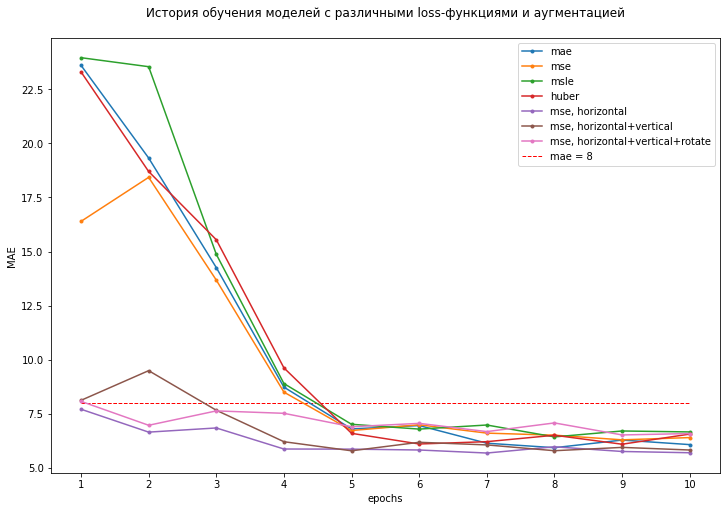

In [12]:
plt.figure(figsize=(12, 8))
plt.title("История обучения моделей с различными loss-функциями и аугментацией\n")
plt.xlabel("epochs")
plt.ylabel("MAE")
x = range(1,11)

plt.hlines(y=8, xmin=1, xmax=10, color='r', linestyle='dashed', label='mae = 8', linewidth=1)     
for k in loss.keys():
    plt.plot(x, loss[k], label = k, marker = '.')

plt.legend()
plt.xticks(x);

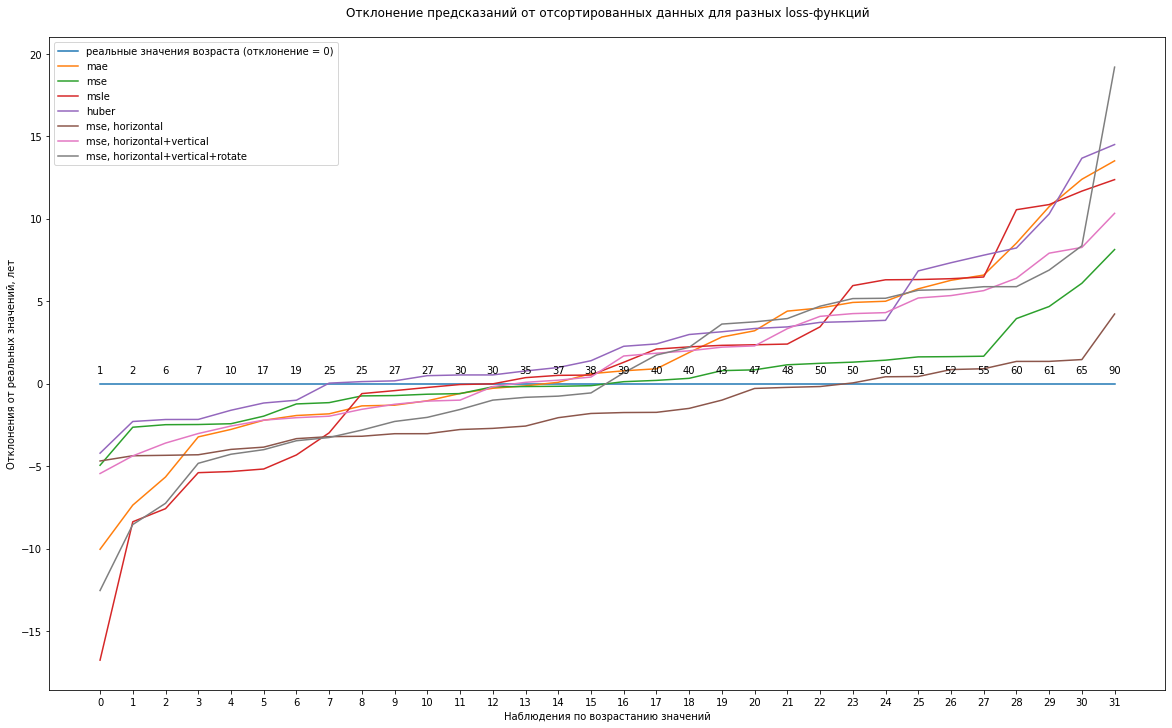

In [13]:
plt.figure(figsize=(20, 12))
plt.title("Отклонение предсказаний от отсортированных данных для разных loss-функций\n")
plt.xlabel("Наблюдения по возрастанию значений")
plt.ylabel("Отклонения от реальных значений, лет")
x = range(32)

plt.plot(x, np.zeros(len(real_values)), label = 'реальные значения возраста (отклонение = 0)')
for k in loss.keys():
    plt.plot(x, sorted([x-y for x, y in zip(pred[k],real_values)]), label = k)

for x0, y0 in zip(x, np.zeros(32)):
    label = sorted(real_values)[x0]
    plt.annotate(label, (x0, y0), textcoords="offset points", xytext=(0, 10), ha='center')

plt.legend()
plt.xticks(x)
plt.show()

**Выводы по п 3**
  - выбранная модель позволяет получить стабильные показатели метрики MAE < 8
  - анализ результатов и визуализация подтверждают, что со средним заданным отклонением модель корректно предсказывает возраст
  - дальнейшим совершенствованием модели могли бы послужить инжиниринг слоев, увеличение числа эпох, обучение модели на различных гиперпараметрах (тип пулинга, скорость обучения, подбор оптимизатора и т.д.)
  - была использована архитектура остаточной сверточной сети ResNet50
  - веса "наследуются" от предобученной модели на датасете ImageNet (более 1 млн изображений в 1000 категорий)
  - мы не включаем последний полносвязный слой, а делаем свой для конкретной задачи
  - замораживание слоев не использовалось, обновлялись веса всех слоев модели
  - использовали 10 эпох, это компромисс между получением стабильной метрики и переобучением, хотя все варианты моделей достигали целевую метрику на 5-й эпохе
  - размер батча мы не указывали, он настраивался автоматически
  - оптимизатор Adam - адаптивный, быстрый, подходит для широкого круга задач
  - была применена аугментация, а именно, было использовано отражение по горизонтали; остальные трансформации, на первый взгляд, не влияют на результат
  - отмечено некритичное переобучение: метрика на тренировочной выборке 2-5, на тестовой 6-7
  - была достигнута целевая метрика MAE < 8, стабильный результат при различных параметрах.

**Общие выводы**
  - была поставлена задача предсказания возраста человека по его фотографии с целью:
    - выработки рекомендаций товаров для покупателей из различных возрастных групп
    - контроль кассиров при продаже алкогольных изделий
  - была выбрана модель популярной предобученной нейронной сети ResNet50
  - обучение модели с настройками по умолчанию и увеличенной скорости обучения до 0.0001 позволило достичь целевого показателя - метрики MAE на тестовом датасете не более 8
  - существует много возможностей для улучшения качества предсказаний модели
  - полученная модель подходит для решения поставленных задач